## Detecting Time Series Anomolies

#### Corey Solitaire

`11.05.2020`

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

## Wrangle:

#### Read in df

In [2]:
df= pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None)
df.head()

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [3]:
df.shape

(719459, 6)

#### Create data frame

In [4]:
df.columns = ['date', 'time', 'page_viewed', 'user_id', 'cohort_id', 'ip']
df["datetime"] = df["date"] + ' '+ df["time"]
df['datetime'] = pd.to_datetime(df.datetime)
df['year'] = df.datetime.dt.year
df['month'] = df.datetime.dt.month
df['day'] = df.datetime.dt.day
df['hour'] = df.datetime.dt.hour
df['weekday'] = df.datetime.dt.day_name()
df = df.astype(object)
df = df.set_index('datetime')
df.drop(columns=['date', 'time'], inplace = True)
df.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
datetime,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,2018,1,26,9,Friday


In [5]:
df.index.dtype

dtype('<M8[ns]')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   page_viewed  719458 non-null  object
 1   user_id      719459 non-null  object
 2   cohort_id    674619 non-null  object
 3   ip           719459 non-null  object
 4   year         719459 non-null  object
 5   month        719459 non-null  object
 6   day          719459 non-null  object
 7   hour         719459 non-null  object
 8   weekday      719459 non-null  object
dtypes: object(9)
memory usage: 54.9+ MB


In [7]:
df.describe()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
count,719458,719459,674619.0,719459,719459,719459,719459,719459,719459
unique,2153,787,40.0,4339,3,12,31,24,7
top,/,11,28.0,97.105.19.58,2020,8,6,9,Monday
freq,40122,14870,60315.0,284579,297548,82040,26592,103242,147497


In [8]:
df.groupby(['user_id','ip']).sum()

cohort_id    year  month   day  hour  \
user_id ip                                                     
1       12.5.63.210         168.0   12114     54   120    84   
        172.56.15.15         64.0   16144     40    32    91   
        172.56.15.203        24.0    6054      9    57    21   
        172.56.15.46          8.0    2018      5    23     7   
        172.56.15.50         16.0    4036      6    26    14   
...                           ...     ...    ...   ...   ...   
784     99.43.143.116      5673.0  187860    955  1938  1161   
785     24.173.208.242       59.0    2020     10    29    11   
        72.181.127.233     1770.0   60600    309   598   315   
786     72.190.25.232       392.0   14140     70   203   105   
787     99.126.113.140       55.0    2020     10    29    22   

                                                                  weekday  
user_id ip                                                                 
1       12.5.63.210                  FridayFridayFridayFridayFridayFriday  
        172.56.15.15     FridayFridayFridayFridayFridayFridayFridayFriday  
        172.56.15.203                                  MondayMondayMonday  
        172.56.15.46                                            Wednesday  
        172.56.15.50                                       TuesdayTuesday  
...                                                                   ...  
784     99.43.143.116   MondayMondayMondayMondayMondayMondayMondayMond...  
785     24.173.208.242                                           Thursday  
        72.181.127.233  MondayTuesdayTuesdayTuesdayTuesdayTuesdayTuesd...  
786     72.190.25.232   ThursdayThursdayThursdayThursdayThursdayThursd...  
787     99.126.113.140                                           Thursday  

[6182 rows x 6 columns]

In [9]:
df.groupby(['cohort_id','ip']).sum()

user_id    year  month   day  hour  \
cohort_id ip                                                   
1.0       107.204.49.22       248    2018     10     3    10   
          107.77.196.213     1332   18162     90   117   207   
          107.77.217.196      444    6057     15    66    48   
          107.77.217.65      1799   14126     63   105     3   
          107.77.220.6        148    2019      7    14     8   
...                           ...     ...    ...   ...   ...   
62.0      98.199.170.30      1500    4040     20    21    26   
          98.39.66.72       18456   48480    254   312   310   
          99.151.201.25    189992  513080   2508  4923  3394   
          99.162.243.68     96516  254520   1225  2440  1472   
          99.5.223.96        3076    8080     40     7    42   

                                                                    weekday  
cohort_id ip                                                                 
1.0       107.204.49.22                                           Wednesday  
          107.77.196.213  SaturdaySaturdaySaturdaySaturdaySaturdaySaturd...  
          107.77.217.196                        WednesdayWednesdayWednesday  
          107.77.217.65   SaturdaySaturdaySaturdaySaturdaySaturdaySaturd...  
          107.77.220.6                                               Sunday  
...                                                                     ...  
62.0      98.199.170.30                                      SaturdaySunday  
          98.39.66.72     WednesdayWednesdayWednesdayThursdayThursdayThu...  
          99.151.201.25   MondayMondayMondayMondayMondayMondayMondayMond...  
          99.162.243.68   MondayMondayMondayMondayMondayMondayMondayMond...  
          99.5.223.96                            ThursdayFridayFridayFriday  

[4605 rows x 6 columns]

In [10]:
df.groupby('ip').count()

,page_viewed,user_id,cohort_id,year,month,day,hour,weekday
ip,,,,,,,,
100.11.170.135,114,114,114,114,114,114,114,114
100.19.73.35,408,408,408,408,408,408,408,408
100.35.67.162,11,11,11,11,11,11,11,11
103.137.12.164,9,9,9,9,9,9,9,9
103.208.220.130,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...
99.97.208.13,44,44,44,44,44,44,44,44
99.97.210.12,18,18,18,18,18,18,18,18
99.98.32.165,267,267,267,267,267,267,267,267


In [11]:
df.groupby('weekday').count()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour
weekday,,,,,,,,
Friday,108531,108531,102208,108531,108531,108531,108531,108531
Monday,147497,147497,138495,147497,147497,147497,147497,147497
Saturday,26474,26474,24612,26474,26474,26474,26474,26474
Sunday,38178,38178,35739,38178,38178,38178,38178,38178
Thursday,128828,128828,119923,128828,128828,128828,128828,128828
Tuesday,141750,141750,133135,141750,141750,141750,141750,141750
Wednesday,128200,128201,120507,128201,128201,128201,128201,128201


In [12]:
df.groupby('weekday')['ip'].count()

weekday
Friday       108531
Monday       147497
Saturday      26474
Sunday        38178
Thursday     128828
Tuesday      141750
Wednesday    128201
Name: ip, dtype: int64

In [13]:
#df.groupby('user_id')['weekday'].count()
df.groupby(["weekday", "hour"])["ip"].count()

weekday    hour
Friday     0        825
           1        382
           2        172
           3         65
           4        150
                   ... 
Wednesday  19      2882
           20      3089
           21      3309
           22      2457
           23      1554
Name: ip, Length: 168, dtype: int64

In [14]:
df.groupby('weekday')["user_id"].sum()

weekday
Friday       42618265
Monday       58637327
Saturday     10773116
Sunday       15859701
Thursday     51461159
Tuesday      54851408
Wednesday    48507185
Name: user_id, dtype: int64

In [15]:
#df.groupby('weekday')["ip"].sum()

***

#### Takeaway

`1. Dataset consists of 720,000 hits on the codeup curriculum.  The data consists of a datetime object, the page that was being viewed, the user id, cohort id, and ip address.`

`2. It appears that students are assigned numbers (user_id) and grouped in to cohorts (cohort_id)`

`3. Students often hit the website from different ip addresses, suggesting hits in a variety of locations`

***

## Explore:

***Research Question:***

`1. Characterize use by hour (3am)`   
`2. Check for any anamolyous features`   

In [16]:
df.groupby('hour')['ip'].count()

hour
0       4988
1       2674
2       1590
3        854
4        937
5       1540
6       3411
7       9079
8      41262
9     103242
10     71375
11     73834
12     39596
13     61157
14     72474
15     66387
16     53282
17     18592
18     15239
19     16121
20     18141
21     18528
22     15242
23      9914
Name: ip, dtype: int64

`1. Most hits observed at 9 am and tapirs off after that`   
`2. After 4 pm activity drops to about 1500 hits`   
`3. Lowest number of hits observed at 3am`   

***

#### Lets look at the ip data for only 3 am

***

In [17]:
df.head(1)

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
datetime,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,2018,1,26,9,Friday


In [18]:
three_am=df[df.hour == 3]
three_am.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
datetime,,,,,,,,,
2018-02-01 03:56:33,/,48,NaN,66.69.62.219,2018,2,1,3,Thursday
2018-02-07 03:14:00,java-ii/object-oriented-programming,48,NaN,66.69.62.219,2018,2,7,3,Wednesday
2018-02-07 03:14:02,slides/object_oriented_programming,48,NaN,66.69.62.219,2018,2,7,3,Wednesday
2018-02-07 03:14:21,java-ii/interfaces-and-abstract-classes,48,NaN,66.69.62.219,2018,2,7,3,Wednesday
2018-02-07 03:14:22,slides/interfaces_and_abstract_classes,48,NaN,66.69.62.219,2018,2,7,3,Wednesday


#### Change formatting of IP address

In [19]:
# Function I found Online
def ip_to_int(ip_ser):
    ips = ip_ser.str.split('.', expand=True).astype(np.int16).values
    mults = np.tile(np.array([24, 16, 8, 0]), len(ip_ser)).reshape(ips.shape)
    return np.sum(np.left_shift(ips, mults), axis=1)

In [20]:
three_am['int_ip'] = ip_to_int(three_am.ip)
three_am.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,int_ip
datetime,,,,,,,,,,
2018-02-01 03:56:33,/,48,NaN,66.69.62.219,2018,2,1,3,Thursday,1111834331
2018-02-07 03:14:00,java-ii/object-oriented-programming,48,NaN,66.69.62.219,2018,2,7,3,Wednesday,1111834331
2018-02-07 03:14:02,slides/object_oriented_programming,48,NaN,66.69.62.219,2018,2,7,3,Wednesday,1111834331
2018-02-07 03:14:21,java-ii/interfaces-and-abstract-classes,48,NaN,66.69.62.219,2018,2,7,3,Wednesday,1111834331
2018-02-07 03:14:22,slides/interfaces_and_abstract_classes,48,NaN,66.69.62.219,2018,2,7,3,Wednesday,1111834331


In [21]:
three_am.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 854 entries, 2018-02-01 03:56:33 to 2020-11-01 03:03:30
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   page_viewed  854 non-null    object
 1   user_id      854 non-null    object
 2   cohort_id    791 non-null    object
 3   ip           854 non-null    object
 4   year         854 non-null    object
 5   month        854 non-null    object
 6   day          854 non-null    object
 7   hour         854 non-null    object
 8   weekday      854 non-null    object
 9   int_ip       854 non-null    int64 
dtypes: int64(1), object(9)
memory usage: 73.4+ KB


In [22]:
three_am1 = three_am.copy()
three_am = three_am[['ip']]

In [23]:
# three_am['ip_count'] = three_am.resample("1D").count()
# gapminder['lifeExp_mean'] = gapminder.groupby('continent').lifeExp.transform('mean')

#### Resample By Day 

In [24]:
df_3 = three_am.resample("1D").count()
df_3

,ip
datetime,
2018-02-01,1
2018-02-02,0
2018-02-03,0
2018-02-04,0
2018-02-05,0
...,...
2020-10-28,0
2020-10-29,0
2020-10-30,1


#### Visualize Data

<Figure size 864x576 with 0 Axes>

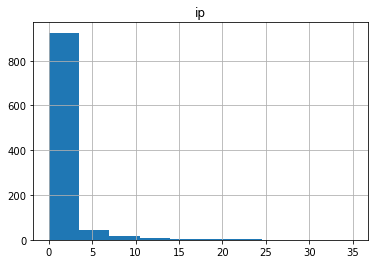

In [25]:
plt.figure(figsize=(12, 8))
df_3.hist()
plt.show()

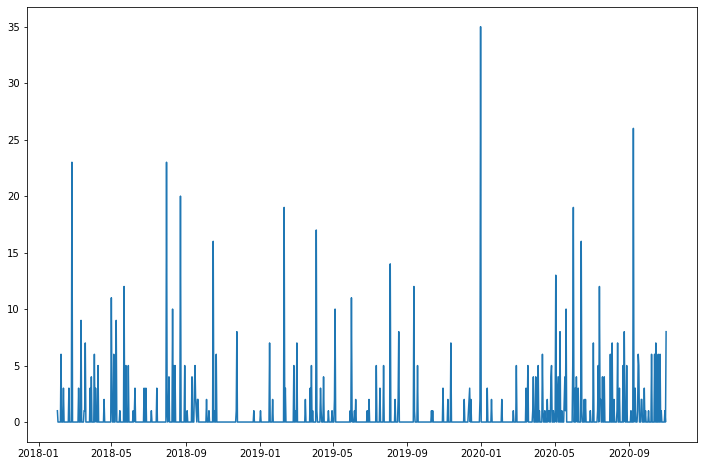

In [26]:
# Visualize Splits (Sanity Check)
x = df_3.index
y = df_3.ip

plt.figure(figsize=(12, 8))
plt.plot(x,y)
plt.show()

`It appears that the general trend in hits at 3am has increased over time, and it appears that creating some Bollinger bands may help to distinguish outliers`

#### Resample Data

#### Split into Train/Test

In [27]:
# 506 Days (.5)
train = df_3[:'2019-06-16']
# 303 Days (.3)
validate = df_3['2019-06-15':'2020-04-15']
# 202 Days (.2)
test = df_3['2020-04-16':]

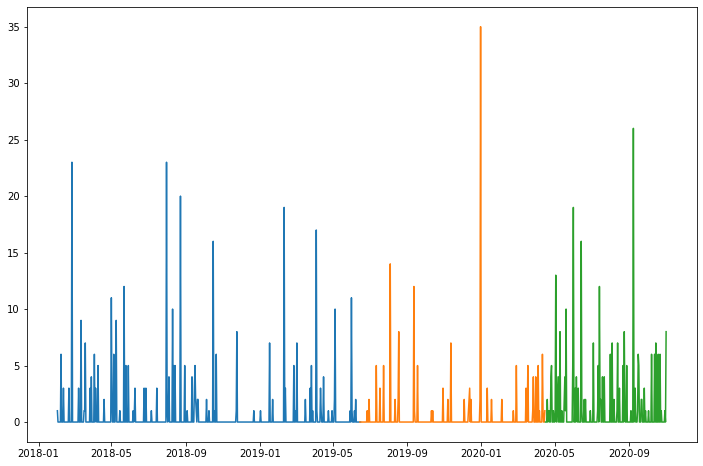

In [28]:
# Visualize Splits (Sanity Check)
plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(validate)
plt.plot(test)
plt.show()

#### Simple Moving Average

In [29]:
# 1 week
sma_short = train.rolling(window=7).mean()
sma_short

,ip
datetime,
2018-02-01,NaN
2018-02-02,NaN
2018-02-03,NaN
2018-02-04,NaN
2018-02-05,NaN
...,...
2019-06-12,0.428571
2019-06-13,0.285714
2019-06-14,0.285714


In [30]:
# 30 days
sma_long = train.rolling(window=30).mean()
sma_long

,ip
datetime,
2018-02-01,NaN
2018-02-02,NaN
2018-02-03,NaN
2018-02-04,NaN
2018-02-05,NaN
...,...
2019-06-12,0.533333
2019-06-13,0.533333
2019-06-14,0.533333


#### Plot the SMA

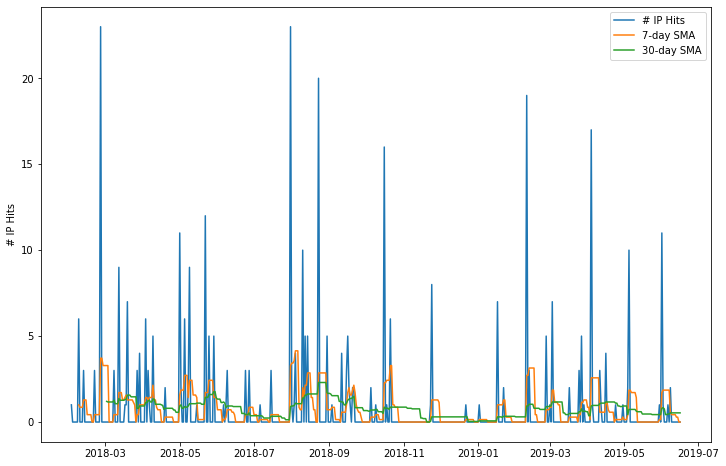

In [31]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, train, label='# IP Hits')

ax.plot(train.index, sma_short, label = '7-day SMA')

ax.plot(train.index, sma_long, label = '30-day SMA')

ax.legend(loc='best')
ax.set_ylabel('# IP Hits')
plt.show()

#### Calculate Exponential Moving Average 
 
`Reduces lag in data by placing a greater weight on more recent data` 

In [32]:
# 7 day 
ema_short = train.ewm(span=7).mean()
ema_short.head()

,ip
datetime,
2018-02-01,1.000000
2018-02-02,0.428571
2018-02-03,0.243243
2018-02-04,0.154286
2018-02-05,0.103713


In [33]:
# 30 day
ema_long = train.ewm(span=30).mean()
ema_long.tail()

,ip
datetime,
2019-06-12,0.636652
2019-06-13,0.595578
2019-06-14,0.557154
2019-06-15,0.521208
2019-06-16,0.487582


#### Comparison of SMA and EMA


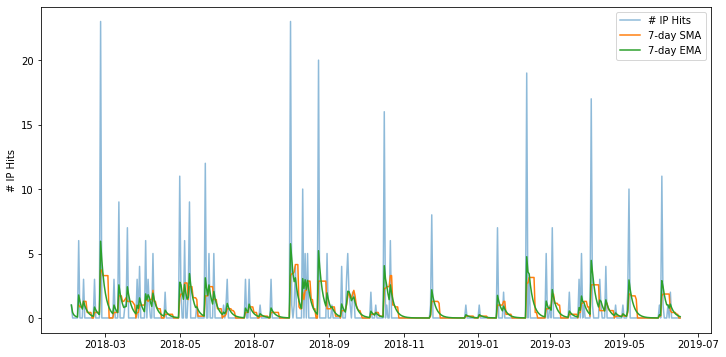

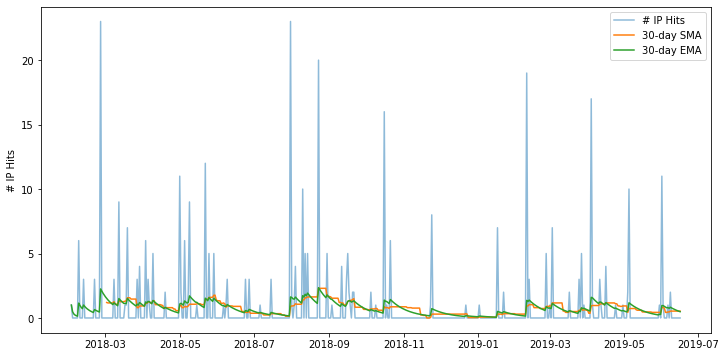

In [34]:


fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='# IP Hits', alpha=.5)

ax.plot(train.index, sma_short, label = '7-day SMA')
ax.plot(train.index, ema_short, label = '7-day EMA')

ax.legend(loc='best')
ax.set_ylabel('# IP Hits')

plt.show()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='# IP Hits', alpha=.5)

ax.plot(train.index, sma_long, label = '30-day SMA')
ax.plot(train.index, ema_long, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('# IP Hits')

plt.show()

#### Bollinger Bands and %b

In [35]:
# set the window span
span = 30

# compute midband
midband = train.ewm(span=span).mean()
midband

,ip
datetime,
2018-02-01,1.000000
2018-02-02,0.483333
2018-02-03,0.311366
2018-02-04,0.225573
2018-02-05,0.174250
...,...
2019-06-12,0.636652
2019-06-13,0.595578
2019-06-14,0.557154


In [36]:
# compute exponential stdev
stdev = train.ewm(span=span).std()
stdev

,ip
datetime,
2018-02-01,NaN
2018-02-02,0.707107
2018-02-03,0.567541
2018-02-04,0.483065
2018-02-05,0.424569
...,...
2019-06-12,2.140405
2019-06-13,2.076311
2019-06-14,2.013723


In [37]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

ub

,ip
datetime,
2018-02-01,NaN
2018-02-02,2.604654
2018-02-03,2.013990
2018-02-04,1.674769
2018-02-05,1.447956
...,...
2019-06-12,7.057866
2019-06-13,6.824512
2019-06-14,6.598324


#### Plot the Bands

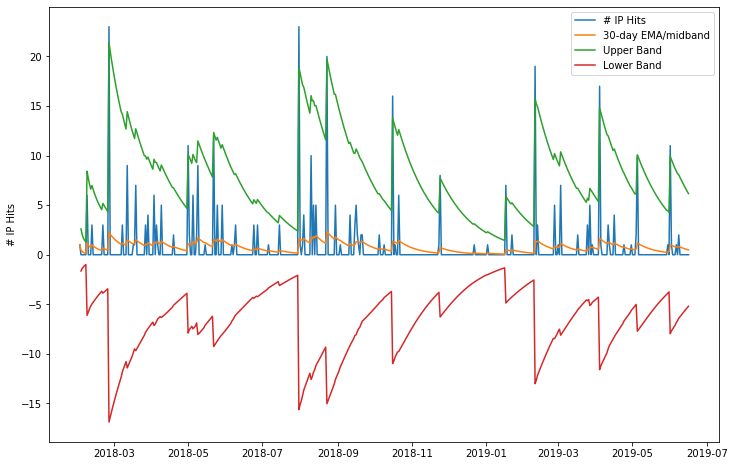

In [38]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, 
        train,
        label='# IP Hits')

ax.plot(train.index, 
        midband, 
        label = '30-day EMA/midband')
ax.plot(train.index, 
        ub, 
        label = 'Upper Band')
ax.plot(train.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('# IP Hits')
plt.show()

#### Computing %b

In [39]:
train = pd.concat([train, midband, ub, lb], axis=1)
train.columns = ['ip_hits', 'midband', 'ub', 'lb']
train.tail()

,ip_hits,midband,ub,lb
datetime,,,,
2019-06-12,0,0.636652,7.057866,-5.784561
2019-06-13,0,0.595578,6.824512,-5.633356
2019-06-14,0,0.557154,6.598324,-5.484016
2019-06-15,0,0.521208,6.379160,-5.336744
2019-06-16,0,0.487582,6.166872,-5.191708


In [40]:
# Creating a percent b column
train['pct_b'] = (train['ip_hits'] - train['lb'])/(train['ub'] - train['lb'])
# Sorting by values > 1
train[train['pct_b']>1]

,ip_hits,midband,ub,lb,pct_b
datetime,,,,,
2018-02-25,23,2.253559,21.380597,-16.873479,1.042333
2018-05-01,11,1.080410,10.054600,-7.893779,1.052673
2018-07-31,23,1.631588,18.890165,-15.626990,1.119066
2018-08-23,20,2.349797,19.732139,-15.032546,1.007705
2018-10-16,16,1.385369,13.743820,-10.973083,1.091281
2018-11-24,8,0.724842,7.729299,-6.279616,1.019323
2019-01-17,7,0.506510,5.877109,-4.864089,1.104541
2019-02-10,19,1.364349,15.734066,-13.005369,1.113639
2019-04-04,17,1.601140,14.790550,-11.588271,1.083758


***
#### Takeaway:

`1. There appear to be 10 days in Train that have an anomolous # of ip_hits`
`2. Next step is to look look at the specific IP addresses per day to see if there is any similarity`

***

#### Lets Rexamine the 3am df

In [41]:
three_am1.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,int_ip
datetime,,,,,,,,,,
2018-02-01 03:56:33,/,48,NaN,66.69.62.219,2018,2,1,3,Thursday,1111834331
2018-02-07 03:14:00,java-ii/object-oriented-programming,48,NaN,66.69.62.219,2018,2,7,3,Wednesday,1111834331
2018-02-07 03:14:02,slides/object_oriented_programming,48,NaN,66.69.62.219,2018,2,7,3,Wednesday,1111834331
2018-02-07 03:14:21,java-ii/interfaces-and-abstract-classes,48,NaN,66.69.62.219,2018,2,7,3,Wednesday,1111834331
2018-02-07 03:14:22,slides/interfaces_and_abstract_classes,48,NaN,66.69.62.219,2018,2,7,3,Wednesday,1111834331


***

## Create a New Df with only Values from Identified Days (Anomalous)

#### Day 1 of 10 [2-25-2018]

In [42]:
one = three_am1.loc['2018-02-25']
#two_twenty_five

#### Day 2 of 10 [5-01-2018]

In [43]:
two = three_am1.loc['2018-05-01']
#five_one

#### Day 3 of 10 [7-31-2018]

In [44]:
three = three_am1.loc['2018-07-31']
#seven_thirty_one

#### Day 4 of 10 [2018-08-23]

In [45]:
four = three_am1.loc['2018-08-23']

#### Day 5 of 10 [2018-10-16]

In [46]:
five = three_am1.loc['2018-10-16']

#### Day 6 of 10 [2018-11-24]

In [47]:
six = three_am1.loc['2018-11-24']

#### Day 7 of 10 [2019-01-17]

In [48]:
seven = three_am1.loc['2019-01-17']

#### Day 8 of 10 [2019-02-10]

In [49]:
eight = three_am1.loc['2019-02-10']

#### Day 9 of 10 [2019-04-04]

In [50]:
nine = three_am1.loc['2019-04-04']
#nine

#### Day 10 of 10 [2019-06-01]

In [51]:
ten = three_am1.loc['2019-06-01']

#### Create total df and combine

In [52]:
total = pd.DataFrame()
total = total.append([one,two,three,four,five,six,seven,eight,nine,ten])  
total.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,int_ip
datetime,,,,,,,,,,
2018-02-25 03:44:48,index.html,53,14,67.10.161.55,2018,2,25,3,Sunday,1124770103
2018-02-25 03:44:56,java-i,53,14,67.10.161.55,2018,2,25,3,Sunday,1124770103
2018-02-25 03:45:21,java-i/introduction-to-java,53,14,67.10.161.55,2018,2,25,3,Sunday,1124770103
2018-02-25 03:45:25,java-i,53,14,67.10.161.55,2018,2,25,3,Sunday,1124770103
2018-02-25 03:45:26,java-i/introduction-to-java,53,14,67.10.161.55,2018,2,25,3,Sunday,1124770103


In [53]:
total.groupby(['user_id','ip']).count()

page_viewed  cohort_id  year  month  day  hour  \
user_id ip                                                                
48      66.69.62.219               4          0     4      4    4     4   
51      72.179.161.39              8          8     8      8    8     8   
53      67.10.161.55              23         23    23     23   23    23   
        67.10.174.56               7          7     7      7    7     7   
127     173.174.190.61            16         16    16     16   16    16   
        64.148.247.227             2          2     2      2    2     2   
155     107.77.64.21               7          7     7      7    7     7   
235     173.175.122.123           41         41    41     41   41    41   
282     99.140.253.42             11         11    11     11   11    11   
283     110.78.138.179            16         16    16     16   16    16   
304     99.203.154.58             19         19    19     19   19    19   
349     24.160.139.8               1          0     1      1    1     1   

                         weekday  int_ip  
user_id ip                                
48      66.69.62.219           4       4  
51      72.179.161.39          8       8  
53      67.10.161.55          23      23  
        67.10.174.56           7       7  
127     173.174.190.61        16      16  
        64.148.247.227         2       2  
155     107.77.64.21           7       7  
235     173.175.122.123       41      41  
282     99.140.253.42         11      11  
283     110.78.138.179        16      16  
304     99.203.154.58         19      19  
349     24.160.139.8           1       1

***

**Takeaway**

`1. 10 user_id found in data`   
`2. Those users each had a specific IP address, except:
         user_id = 53 (67.10.161.55 and 67.10.174.56)
         user_id = 127 (173.174.190.61 and 64.148.247.227)`   

***

## Who is user_id 53 ?

In [54]:
user_53 = df[df.user_id == 53]
user_53.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
datetime,,,,,,,,,
2018-01-28 18:48:19,index.html,53,14,67.10.161.55,2018,1,28,18,Sunday
2018-01-28 18:48:24,html-css,53,14,67.10.161.55,2018,1,28,18,Sunday
2018-01-28 18:49:20,javascript-i,53,14,67.10.161.55,2018,1,28,18,Sunday
2018-01-28 18:49:23,javascript-i/conditionals,53,14,67.10.161.55,2018,1,28,18,Sunday
2018-01-28 18:50:41,javascript-i/conditionals,53,14,67.10.161.55,2018,1,28,18,Sunday


In [55]:
user_53.shape

(10874, 9)

In [56]:
user_53.ip.value_counts()

97.105.19.58       4895
67.10.174.56       2926
97.105.19.61       2307
67.10.161.55        651
192.171.117.210      36
173.175.82.174       23
173.174.212.111      18
50.84.218.3           5
98.6.52.59            5
72.128.136.219        5
107.77.221.110        2
75.54.33.178          1
Name: ip, dtype: int64

In [57]:
user_53.page_viewed.isnull().sum()

0

In [58]:
mask = user_53.page_viewed.str.contains('javascript')
user_53[mask].shape

(1823, 9)

In [59]:
mask = user_53.page_viewed.str.contains('css')
user_53[mask].shape

(1256, 9)

In [60]:
mask = user_53.page_viewed.str.contains('java')
user_53[mask].shape

(4289, 9)

#### Pipe Search Criteria

In [61]:
mask = (user_53.page_viewed.str.contains('javascript') | user_53.page_viewed.str.contains('css') | user_53.page_viewed.str.contains('java'))
user_53[mask].shape

(5545, 9)

***

**Takeaway:**

`1. Out of 10,000 pages, user_53 referenced javascript 5545 times`   
`2. user_53 is most likely a webdev student`   
***

## Who is user_id 127 ?

In [62]:
user_127 = df[df.user_id == 127]
user_127.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
datetime,,,,,,,,,
2018-03-05 15:22:21,/,127,23,97.105.19.61,2018,3,5,15,Monday
2018-03-05 15:22:32,html-css,127,23,97.105.19.61,2018,3,5,15,Monday
2018-03-05 15:31:45,html-css/introduction,127,23,97.105.19.61,2018,3,5,15,Monday
2018-03-05 15:35:25,html-css,127,23,97.105.19.61,2018,3,5,15,Monday
2018-03-05 15:41:05,html-css,127,23,97.105.19.61,2018,3,5,15,Monday


In [63]:
user_127.shape

(2598, 9)

In [64]:
mask = (user_127.page_viewed.str.contains('javascript') | user_127.page_viewed.str.contains('css') | user_127.page_viewed.str.contains('java'))
user_127[mask].shape

(1160, 9)

In [65]:
user_127.ip.value_counts()

97.105.19.61       1320
64.148.247.227      296
173.174.190.61      209
24.153.217.26       180
69.147.62.1         139
70.123.162.206      111
70.123.169.229       74
97.105.19.58         30
192.171.117.210      24
99.132.128.74        24
70.121.181.181       20
174.128.181.39       20
192.67.54.12         13
107.204.52.24        13
68.203.198.221       12
72.177.209.244       10
69.212.157.148        9
24.214.254.251        7
172.58.67.44          6
172.56.7.244          6
24.243.40.41          6
72.48.1.140           5
104.5.221.205         5
67.54.151.131         4
72.179.184.241        4
72.48.8.218           4
70.117.71.59          3
192.241.205.66        3
172.58.109.252        3
172.58.111.180        3
172.58.105.205        3
172.56.6.51           3
99.48.229.126         2
172.58.109.183        2
172.58.110.34         2
172.58.99.59          2
72.190.185.235        2
172.58.67.181         2
172.58.111.204        2
172.58.109.6          2
172.58.108.182        2
174.128.181.119 

***

**Takeaway:**

`1. Out of 2598 pages, user_127 referenced javascript 1160 times`   
`2. user_127 is most likely a webdev student`   
***

## Using String Can We ID Cohorts

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   page_viewed  719458 non-null  object
 1   user_id      719459 non-null  object
 2   cohort_id    674619 non-null  object
 3   ip           719459 non-null  object
 4   year         719459 non-null  object
 5   month        719459 non-null  object
 6   day          719459 non-null  object
 7   hour         719459 non-null  object
 8   weekday      719459 non-null  object
dtypes: object(9)
memory usage: 54.9+ MB


In [67]:
df.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
datetime,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,2018,1,26,9,Friday


In [68]:
# Creating a column for webdev based on boolen mask
df['webdev'] = (df.page_viewed.str.contains('javascript') | df.page_viewed.str.contains('css') | df.page_viewed.str.contains('java') | df.page_viewed.str.contains('programming') | df.page_viewed.str.contains('jquery')) 
df.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,2018,1,26,9,Friday,True
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,2018,1,26,9,Friday,True
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,2018,1,26,9,Friday,True
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,2018,1,26,9,Friday,True


In [69]:
# What are predicted webdev cohorts?
mask = df.webdev == True
true = df[mask]

In [70]:
true.cohort_id.value_counts().count()

37

In [71]:
true.cohort_id.value_counts()

33.0    27633
29.0    24590
53.0    23017
28.0    22923
24.0    22578
57.0    20716
32.0    20320
56.0    20154
51.0    19333
58.0    19258
26.0    18779
52.0    17980
23.0    17416
25.0    17115
22.0    16405
31.0    16322
27.0    13221
61.0     8316
62.0     6845
1.0      5539
14.0     5197
21.0     3310
17.0     3205
18.0     1138
8.0       810
13.0      654
19.0      333
16.0      321
7.0       314
15.0      260
12.0      140
11.0      140
34.0       62
6.0        45
2.0        13
9.0         4
55.0        1
Name: cohort_id, dtype: int64

In [72]:
# Real cohorts vs Fake cohorts
true[true.cohort_id == 2]

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2018-10-03 10:45:07,java-i,280,2,192.171.117.210,2018,10,3,10,Wednesday,True
2018-10-03 10:46:26,javascript-i,280,2,192.171.117.210,2018,10,3,10,Wednesday,True
2018-11-12 15:48:36,content/html-css,280,2,104.58.135.163,2018,11,12,15,Monday,True
2018-11-12 15:48:51,content/html-css/introduction.html,280,2,104.58.135.163,2018,11,12,15,Monday,True
2019-02-07 12:14:18,html-css,280,2,104.58.135.163,2019,2,7,12,Thursday,True
2019-03-22 23:27:00,javascript-ii/map-filter-reduce,396,2,67.11.97.204,2019,3,22,23,Friday,True
2019-03-22 23:30:48,javascript-ii/es6,396,2,67.11.97.204,2019,3,22,23,Friday,True
2019-03-22 23:34:06,javascript-ii/map-filter-reduce,396,2,67.11.97.204,2019,3,22,23,Friday,True
2019-03-22 23:34:14,javascript-ii/promises,396,2,67.11.97.204,2019,3,22,23,Friday,True


***
**Findings:**
`I feel confident that the above cohorts are webdeb`

***

***

In [73]:
mask = df.webdev == False
false = df[mask]

In [74]:
false.cohort_id.value_counts().count()

40

In [75]:
false.cohort_id.value_counts()

28.0    37392
34.0    25119
59.0    22425
55.0    20410
22.0    13923
24.0    13046
53.0    13030
29.0    12958
33.0    12535
57.0    11731
56.0    11516
23.0    10913
51.0    10355
52.0     9538
58.0     9096
31.0     8931
26.0     8858
25.0     8312
32.0     8013
27.0     7226
14.0     4298
21.0     4134
61.0     3458
1.0      3345
13.0     2079
62.0     1873
17.0     1720
8.0       902
18.0      867
19.0      832
15.0      431
16.0      422
7.0       181
12.0      162
2.0        80
11.0       68
6.0        27
4.0         4
9.0         1
5.0         1
Name: cohort_id, dtype: int64

In [76]:
false[false.cohort_id == 4]

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2018-02-04 11:21:38,/,85,4,66.42.139.162,2018,2,4,11,Sunday,False
2018-02-04 11:23:27,mkdocs/search_index.json,85,4,66.42.139.162,2018,2,4,11,Sunday,False
2018-02-04 11:24:05,prework/databases,85,4,66.42.139.162,2018,2,4,11,Sunday,False
2018-02-04 11:24:56,prework/versioning/github,85,4,66.42.139.162,2018,2,4,11,Sunday,False


In [77]:
false.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:59:22,mkdocs/search_index.json,5,22,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 10:00:37,/,6,22,97.105.19.61,2018,1,26,10,Friday,False
2018-01-26 10:08:22,mkdocs/search_index.json,10,21,97.105.19.61,2018,1,26,10,Friday,False
2018-01-26 10:08:34,git/merge-conflict-demo,10,21,97.105.19.61,2018,1,26,10,Friday,False


***
**Findings:**
`I feel confident that the above cohorts are datascience except 5 and 9`

***

## Can I find Darden as a Cohort?

In [78]:
# We are the most recent cohort, so we should be the most recent number
false.cohort_id.value_counts()

28.0    37392
34.0    25119
59.0    22425
55.0    20410
22.0    13923
24.0    13046
53.0    13030
29.0    12958
33.0    12535
57.0    11731
56.0    11516
23.0    10913
51.0    10355
52.0     9538
58.0     9096
31.0     8931
26.0     8858
25.0     8312
32.0     8013
27.0     7226
14.0     4298
21.0     4134
61.0     3458
1.0      3345
13.0     2079
62.0     1873
17.0     1720
8.0       902
18.0      867
19.0      832
15.0      431
16.0      422
7.0       181
12.0      162
2.0        80
11.0       68
6.0        27
4.0         4
9.0         1
5.0         1
Name: cohort_id, dtype: int64

In [79]:
# Sanity Check  
false[false.cohort_id == 62]

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2020-09-21 14:20:32,/,748,62,99.151.201.25,2020,9,21,14,Monday,False
2020-09-21 14:20:49,/,749,62,70.94.132.38,2020,9,21,14,Monday,False
2020-09-21 14:20:53,/,750,62,45.20.118.158,2020,9,21,14,Monday,False
2020-09-21 14:20:58,toc,750,62,45.20.118.158,2020,9,21,14,Monday,False
2020-09-21 14:20:59,/,751,62,47.188.180.229,2020,9,21,14,Monday,False
...,...,...,...,...,...,...,...,...,...,...
2020-11-02 15:24:39,appendix,767,62,75.1.83.45,2020,11,2,15,Monday,False
2020-11-02 15:29:38,appendix/extra-challenges/basic-challenges,767,62,75.1.83.45,2020,11,2,15,Monday,False
2020-11-02 15:33:31,toc,764,62,72.190.174.52,2020,11,2,15,Monday,False


`jquerry is a javascript program, I need to add this keyword in my criteria and start again'

In [80]:
# Maybe 59? 
darden = false[false.cohort_id == 59]
darden.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2020-07-13 14:34:44,/,678,59,76.201.20.193,2020,7,13,14,Monday,False
2020-07-13 14:37:22,/,679,59,24.28.146.155,2020,7,13,14,Monday,False
2020-07-13 14:38:28,/,680,59,136.50.56.155,2020,7,13,14,Monday,False
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59,24.28.146.155,2020,7,13,14,Monday,False
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,2020,7,13,14,Monday,False


***
**Takeaway:** `Timeframe looks right`
***

In [81]:
corey = darden[darden.ip == '70.120.16.59']
corey.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2020-07-13 14:40:03,/,684,59,70.120.16.59,2020,7,13,14,Monday,False
2020-07-13 14:40:39,1-fundamentals/1.1-intro-to-data-science,684,59,70.120.16.59,2020,7,13,14,Monday,False
2020-07-13 14:40:40,1-fundamentals/modern-data-scientist.jpg,684,59,70.120.16.59,2020,7,13,14,Monday,False
2020-07-13 14:40:40,1-fundamentals/AI-ML-DL-timeline.jpg,684,59,70.120.16.59,2020,7,13,14,Monday,False
2020-07-13 14:42:43,1-fundamentals/1.1-intro-to-data-science,684,59,70.120.16.59,2020,7,13,14,Monday,False


## Can I Figure out Teach IP Address by looking at unique Addresses per Cohort

In [82]:
darden.ip.unique()

array(['76.201.20.193', '24.28.146.155', '136.50.56.155',
       '108.239.188.205', '68.54.110.249', '173.174.165.12',
       '70.120.16.59', '99.76.233.212', '72.177.148.181',
       '99.132.128.255', '70.125.137.220', '72.181.127.233',
       '67.11.40.170', '66.69.83.140', '96.8.130.201', '136.50.3.247',
       '96.8.130.186', '162.197.239.66', '173.174.200.226',
       '67.11.85.236', '136.50.70.27', '184.226.101.48', '70.120.73.115',
       '184.203.177.106', '173.123.90.87', '67.11.185.253',
       '184.203.105.40', '173.149.157.87', '24.28.145.253',
       '173.123.150.183', '99.203.90.58', '173.174.236.31',
       '173.127.80.254', '184.226.64.13', '173.149.209.79',
       '192.171.117.210', '173.149.157.75', '173.123.149.62',
       '99.203.26.44', '173.127.48.40', '173.127.8.49', '173.123.172.254',
       '184.203.160.10', '67.11.185.104', '107.77.222.195',
       '184.223.233.47', '107.77.222.138', '12.132.167.253',
       '173.149.192.116', '184.226.114.60', '75.15.245.84',

In [83]:
ip_instructor = pd.DataFrame()
ip_instructor.head()

""


In [84]:
#darden
darden = false[false.cohort_id == 59]
darden = pd.DataFrame(darden.ip.unique())

In [85]:
# Cohort 34 (Verified Data Science)
bayes = false[false.cohort_id == 34]
bayes = pd.DataFrame(bayes.ip.unique())

In [86]:
# Cohort 28 (Verified Data Science)
ada = false[false.cohort_id == 28]
ada = pd.DataFrame(ada.ip.unique())

In [87]:
#Cohort 55
curie = false[false.cohort_id == 55]
curie = pd.DataFrame(curie.ip.unique())

In [88]:
ip_instructor = pd.concat([darden, bayes, ada, curie], axis=1)
ip_instructor.columns = ['darden', 'bayes', 'ada', 'curie']
ip_instructor.head()

,darden,bayes,ada,curie
0,76.201.20.193,97.105.19.58,170.248.173.247,97.105.19.58
1,24.28.146.155,67.11.115.125,97.105.19.58,70.130.127.113
2,136.50.56.155,172.8.173.224,72.177.229.125,72.190.187.173
3,108.239.188.205,173.175.104.33,67.10.174.56,69.231.92.35
4,68.54.110.249,12.197.196.242,170.248.173.246,64.250.9.181


In [89]:
d = ip_instructor['darden'].tolist()
c = ip_instructor['curie'].tolist()
b = ip_instructor['bayes'].tolist()
a = ip_instructor['ada'].tolist()

In [90]:
def common_member(a, b): 
    a_set = set(a) 
    b_set = set(b) 
  
    if (a_set & b_set): 
        print(a_set & b_set) 
    else: 
        print("No common elements")  

In [91]:
common_member(d,c)

{'192.171.117.210'}


In [92]:
common_member(d,b)

{nan, '12.97.187.252', '96.8.130.195', '96.8.130.240', '192.171.117.210'}


In [93]:
common_member(d,a)

{nan, '192.171.117.210'}


In [94]:
common_member(a,b)

{nan, '97.105.19.58', '24.27.227.129', '12.247.3.50', '24.27.227.1', '12.5.63.210', '192.171.117.210', '75.1.166.163'}


In [95]:
common_member(a,c)

{'12.247.3.50', '192.171.117.210', '97.105.19.58', '72.128.136.219'}


In [96]:
common_member(b,c)

{'24.153.137.59', '172.58.107.104', '97.105.19.58', '12.247.3.50', '107.77.217.37', '172.58.110.148', '192.171.117.210'}


## Instructor IP Address

#### 192.171.117.210  (Observed in A,B,C,D)
#### 97.105.19.58        (Observed in A,B,C) - Codeup / Geekdom
#### 12.247.3.50          (Observed in A,B,C) - Codeup / Geekdom

***

## Search for Instructors Continues

In [97]:
false.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:59:22,mkdocs/search_index.json,5,22,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 10:00:37,/,6,22,97.105.19.61,2018,1,26,10,Friday,False
2018-01-26 10:08:22,mkdocs/search_index.json,10,21,97.105.19.61,2018,1,26,10,Friday,False
2018-01-26 10:08:34,git/merge-conflict-demo,10,21,97.105.19.61,2018,1,26,10,Friday,False


In [98]:
# Maggie started working 2 years ago
two_year = false[false.year == 2018]
two_year.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:59:22,mkdocs/search_index.json,5,22,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 10:00:37,/,6,22,97.105.19.61,2018,1,26,10,Friday,False
2018-01-26 10:08:22,mkdocs/search_index.json,10,21,97.105.19.61,2018,1,26,10,Friday,False
2018-01-26 10:08:34,git/merge-conflict-demo,10,21,97.105.19.61,2018,1,26,10,Friday,False


In [99]:
# She would work on the weekends
two_year = two_year[two_year.weekday == 'Saturday']
two_year.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2018-01-27 00:01:00,/,23,22,108.65.244.91,2018,1,27,0,Saturday,False
2018-01-27 00:21:30,/,23,22,108.65.244.91,2018,1,27,0,Saturday,False
2018-01-27 00:39:16,spring/fundamentals/services,15,21,174.207.5.52,2018,1,27,0,Saturday,False
2018-01-27 00:41:15,/,15,21,174.207.5.52,2018,1,27,0,Saturday,False
2018-01-27 00:41:20,spring,15,21,174.207.5.52,2018,1,27,0,Saturday,False


In [100]:
two_year.user_id.unique()

array([23, 15, 50, 22, 38, 51, 1, 19, 45, 3, 28, 17, 7, 47, 10, 52, 30,
       29, 25, 81, 82, 4, 41, 6, 16, 83, 2, 36, 27, 33, 57, 95, 58, 65,
       11, 56, 39, 42, 48, 74, 8, 68, 88, 53, 64, 12, 35, 70, 113, 105, 5,
       132, 43, 54, 128, 111, 110, 99, 138, 135, 18, 102, 60, 116, 145,
       129, 131, 160, 157, 31, 167, 155, 127, 86, 79, 142, 90, 67, 14, 37,
       153, 123, 171, 120, 20, 178, 180, 124, 197, 179, 96, 200, 186, 204,
       210, 195, 188, 190, 185, 166, 162, 72, 156, 203, 118, 103, 159,
       119, 215, 136, 199, 198, 196, 192, 26, 191, 217, 240, 183, 232,
       207, 237, 223, 225, 230, 228, 218, 231, 224, 221, 236, 243, 235,
       61, 201, 130, 229, 40, 249, 253, 257, 184, 211, 274, 275, 266, 208,
       276, 273, 272, 222, 219, 264, 262, 148, 252, 193, 256, 270, 258,
       220, 297, 310, 302, 234, 312, 307, 290, 239, 260, 291, 304, 241,
       263, 282, 271, 285, 277, 288, 313, 287], dtype=object)

In [101]:
two_year.cohort_id.unique()

array([22.0, 21.0, 13.0, 8.0, 18.0, 14.0, 1.0, nan, 19.0, 23.0, 17.0,
       24.0, 15.0, 25.0, 16.0, 26.0, 27.0, 28.0], dtype=object)

In [102]:
len(two_year.cohort_id.unique())

18

In [103]:
len(two_year.user_id.unique())

181

***
**Takeaway:**  

#### 317 Users in 2018 , 25 unique cohort id's including one nan

***

In [104]:
two_year[two_year.cohort_id == 22]

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2018-01-27 00:01:00,/,23,22,108.65.244.91,2018,1,27,0,Saturday,False
2018-01-27 00:21:30,/,23,22,108.65.244.91,2018,1,27,0,Saturday,False
2018-01-27 08:30:03,/,19,22,96.8.150.23,2018,1,27,8,Saturday,False
2018-01-27 13:23:44,/,19,22,96.8.150.23,2018,1,27,13,Saturday,False
2018-01-27 14:05:18,/,3,22,72.191.29.130,2018,1,27,14,Saturday,False
...,...,...,...,...,...,...,...,...,...,...
2018-12-29 01:14:07,mysql/relationships,155,22,45.31.212.143,2018,12,29,1,Saturday,False
2018-12-29 01:14:08,mysql/relationships/indexes,155,22,45.31.212.143,2018,12,29,1,Saturday,False
2018-12-29 01:14:25,mysql/database-design,155,22,45.31.212.143,2018,12,29,1,Saturday,False


In [105]:
two_year.groupby(['cohort_id', 'ip']).count()

page_viewed  user_id  year  month  day  hour  \
cohort_id ip                                                              
1.0       107.77.196.213             6        6     6      6    6     6   
          107.77.217.65              2        2     2      2    2     2   
          172.56.14.78               2        2     2      2    2     2   
          173.173.121.126            1        1     1      1    1     1   
          24.26.238.218              5        5     5      5    5     5   
...                                ...      ...   ...    ...  ...   ...   
27.0      72.181.113.238             1        1     1      1    1     1   
          98.6.75.74                 1        1     1      1    1     1   
          99.203.27.199              3        3     3      3    3     3   
          99.98.36.168               9        9     9      9    9     9   
28.0      72.177.229.125             2        2     2      2    2     2   

                           weekday  webdev  
cohort_id ip                                
1.0       107.77.196.213         6       6  
          107.77.217.65          2       2  
          172.56.14.78           2       2  
          173.173.121.126        1       1  
          24.26.238.218          5       5  
...                            ...     ...  
27.0      72.181.113.238         1       1  
          98.6.75.74             1       1  
          99.203.27.199          3       3  
          99.98.36.168           9       9  
28.0      72.177.229.125         2       2  

[274 rows x 8 columns]

*** 

***

## New Plan of Attack
- Step #1: df for 2018, 2019, 2020 sorted by Saturday (IP Address)
- Step #2: look for analagous ip addresses between df
***

In [106]:
instructor_ip = pd.DataFrame()
ateen = false[false.year == 2018]
ateen = ateen[ateen.weekday == 'Saturday']
ateen = pd.DataFrame(ateen.ip.unique())

niteen = false[false.year == 2019]
niteen = niteen[niteen.weekday == 'Saturday']
niteen = pd.DataFrame(niteen.ip.unique())

twenty = false[false.year == 2020]
twenty = twenty[twenty.weekday == 'Saturday']
twenty = pd.DataFrame(twenty.ip.unique())

instructor_ip = pd.concat([ateen, niteen, twenty], axis=1)
instructor_ip.columns = ['ateen', 'niteen', 'twenty']
instructor_ip.head()

,ateen,niteen,twenty
0,108.65.244.91,108.218.193.28,67.11.215.97
1,174.207.5.52,67.11.239.2,66.25.173.125
2,24.26.254.147,173.174.253.193,99.100.172.39
3,107.204.132.6,136.50.29.193,70.123.193.100
4,173.174.155.172,99.158.247.126,97.105.19.58


In [107]:
ateen = instructor_ip['ateen'].tolist()
niteen = instructor_ip['niteen'].tolist()
twenty = instructor_ip['twenty'].tolist()

In [108]:
def common_member(a, b): 
    a_set = set(a) 
    b_set = set(b) 
  
    if (a_set & b_set): 
        return (a_set & b_set) 
    else: 
        print("No common elements")  

In [109]:
len(common_member(ateen, niteen))

40

In [110]:
len(common_member(niteen, twenty))

62

In [111]:
len(common_member(ateen, twenty))

11

In [112]:
sat = common_member(ateen, twenty)
sat

{'107.204.50.101',
 '108.174.85.238',
 '12.247.3.50',
 '192.171.117.210',
 '67.10.174.56',
 '67.11.215.97',
 '71.136.252.51',
 '76.185.131.226',
 '76.204.31.63',
 '97.105.19.58',
 '99.158.248.205'}

**One of these is most likely Maggies**

***

## Now Sunday, hahahaha...

In [113]:
sinstructor_ip = pd.DataFrame()
sateen = false[false.year == 2018]
sateen = sateen[sateen.weekday == 'Sunday']
sateen = pd.DataFrame(sateen.ip.unique())

In [114]:
sniteen = false[false.year == 2019]
sniteen = sniteen[sniteen.weekday == 'Sunday']
sniteen = pd.DataFrame(sniteen.ip.unique())

In [115]:
stwenty = false[false.year == 2020]
stwenty = stwenty[stwenty.weekday == 'Sunday']
stwenty = pd.DataFrame(stwenty.ip.unique())

In [116]:
sinstructor_ip = pd.concat([sateen, sniteen, stwenty], axis=1)
sinstructor_ip.columns = ['ateen', 'niteen', 'twenty']
sinstructor_ip.head()

,ateen,niteen,twenty
0,96.8.179.59,108.199.117.106,173.174.211.244
1,70.114.139.150,76.185.234.111,216.177.165.194
2,72.181.117.226,24.26.235.139,97.105.19.58
3,162.232.155.19,70.118.8.243,76.185.131.226
4,71.42.140.139,72.181.106.116,172.124.64.127


In [117]:
ateen = sinstructor_ip['ateen'].tolist()
niteen = sinstructor_ip['niteen'].tolist()
twenty = sinstructor_ip['twenty'].tolist()

In [118]:
len(common_member(ateen, twenty))

11

In [119]:
sun = common_member(ateen, twenty)
sun

{'104.219.136.100',
 '192.171.117.210',
 '45.23.251.14',
 '67.10.174.56',
 '67.11.215.97',
 '71.136.252.51',
 '71.41.8.13',
 '72.181.106.116',
 '72.181.109.196',
 '76.185.131.226',
 '99.57.17.35'}

In [120]:
sat

{'107.204.50.101',
 '108.174.85.238',
 '12.247.3.50',
 '192.171.117.210',
 '67.10.174.56',
 '67.11.215.97',
 '71.136.252.51',
 '76.185.131.226',
 '76.204.31.63',
 '97.105.19.58',
 '99.158.248.205'}

## Possible Instructor IP Addresses (Sat and Sun Hits since 2008)

- 76.185.131.226
- 71.136.252.51
- 67.11.215.97
- 67.10.174.56
- 192.171.117.210

- To find faith cross reference curie with these numbers

## Curie Cohort

In [121]:
curie = false[false.cohort_id == 55]
curie = curie[curie.weekday == 'Monday']
curie = pd.DataFrame(curie.ip.unique())
faith = common_member(curie, twenty)
faith

No common elements


***No Luck There**

***

## Lets take a look at the IP address and get a date range and cohort_id

***

#### User_1

In [122]:
user_1 = df[df.ip == '76.185.131.226']
user_1.head(1)

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2018-02-10 13:53:11,/,11,1,76.185.131.226,2018,2,10,13,Saturday,False


In [123]:
user_1.tail(1)

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2020-11-02 10:10:06,timeseries/modeling-lesson1,11,28,76.185.131.226,2020,11,2,10,Monday,False


`**I think that this is the one**`

***

#### User_2

In [124]:
user_2 = df[df.ip == '71.136.252.51']
user_2.head(1)

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2018-08-25 18:49:05,/,130,23,71.136.252.51,2018,8,25,18,Saturday,False


In [125]:
user_2.tail(1)

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2020-03-31 17:09:28,java-i/introduction-to-java,252,23,71.136.252.51,2020,3,31,17,Tuesday,True


***

#### User_3

In [126]:
user_3 = df[df.ip == '67.11.215.97']
user_3.head(1)

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2018-09-22 21:35:49,toc,272,26,67.11.215.97,2018,9,22,21,Saturday,False


In [127]:
user_3.tail(1)

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2020-08-13 06:49:14,html-css/css-i/flexbox/flexbox-in-practice,515,33,67.11.215.97,2020,8,13,6,Thursday,True


***

#### User_4

In [128]:
user_4 = df[df.ip == '67.10.174.56']
user_4.head(1)

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2018-08-12 18:07:51,mysql/tables,53,14,67.10.174.56,2018,8,12,18,Sunday,False


In [129]:
user_4.tail(1)

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2020-11-02 16:09:45,javascript-i/bom-and-dom/dom,53,28,67.10.174.56,2020,11,2,16,Monday,True


***

#### User_5

In [130]:
user_5 = df[df.ip == '192.171.117.210']
user_5.head(1)

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2018-01-26 12:37:53,/,37,19,192.171.117.210,2018,1,26,12,Friday,False


In [131]:
user_5.tail(1)

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2020-08-27 13:10:52,jquery/ajax/weather-map,506,51,192.171.117.210,2020,8,27,13,Thursday,True


***

## Is cohort 1 for Teachers?

In [132]:
cohort_1 = df[df.cohort_id == 28]
cohort_1 = cohort_1[cohort_1.webdev == False]
cohort_1.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2018-12-06 15:31:29,spring,40,28,170.248.173.247,2018,12,6,15,Thursday,False
2018-12-06 15:31:33,spring/fundamentals/security,40,28,170.248.173.247,2018,12,6,15,Thursday,False
2018-12-06 15:33:32,appendix/further-reading/spring/authorization,40,28,170.248.173.247,2018,12,6,15,Thursday,False
2018-12-06 15:34:29,spring/fundamentals/security/authentication,40,28,170.248.173.247,2018,12,6,15,Thursday,False
2018-12-06 15:38:58,appendix/further-reading/spring/authorization,40,28,170.248.173.247,2018,12,6,15,Thursday,False


In [133]:
len(cohort_1.ip.unique())

218

In [134]:
cohort_1.tail()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2020-11-02 16:42:00,/,314,28,72.178.123.235,2020,11,2,16,Monday,False
2020-11-02 16:42:02,anomaly-detection/overview,11,28,76.185.145.231,2020,11,2,16,Monday,False
2020-11-02 16:42:02,anomaly-detection/AnomalyDetectionCartoon.jpeg,11,28,76.185.145.231,2020,11,2,16,Monday,False
2020-11-02 16:42:04,anomaly-detection/detecting-with-clustering,11,28,76.185.145.231,2020,11,2,16,Monday,False
2020-11-02 16:42:06,anomaly-detection/detecting-timeseries-anomalies,11,28,76.185.145.231,2020,11,2,16,Monday,False


***

## Darden:

In [135]:
darden = false[false.cohort_id == 59]
darden.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,webdev
datetime,,,,,,,,,,
2020-07-13 14:34:44,/,678,59,76.201.20.193,2020,7,13,14,Monday,False
2020-07-13 14:37:22,/,679,59,24.28.146.155,2020,7,13,14,Monday,False
2020-07-13 14:38:28,/,680,59,136.50.56.155,2020,7,13,14,Monday,False
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59,24.28.146.155,2020,7,13,14,Monday,False
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,2020,7,13,14,Monday,False


In [136]:
len(darden.ip.unique())

155

In [137]:
len(darden.user_id.unique())

28

In [138]:
#darden = darden.user_id.unique()
#darden

In [143]:

ip_darden = darden.groupby('user_id')['page_viewed'].count()
ip_darden


user_id
268     781
678     937
679      11
680     847
681    1270
682    1184
683     168
684     853
685    2542
686     725
687     732
688    1248
689    1544
690     663
691    1222
692    1261
693     429
694     567
695     702
696     858
697      13
698    1695
699    1420
739     522
780      52
781      94
783      54
785      31
Name: page_viewed, dtype: int64

In [152]:
darden_page_viewed = pd.DataFrame(darden.page_viewed.resample('D').count())
darden_page_viewed.columns = ['page_view_count']
darden_page_viewed

,page_view_count
datetime,
2020-07-13,157
2020-07-14,522
2020-07-15,440
2020-07-16,1326
2020-07-17,291
...,...
2020-10-29,113
2020-10-30,130
2020-10-31,37


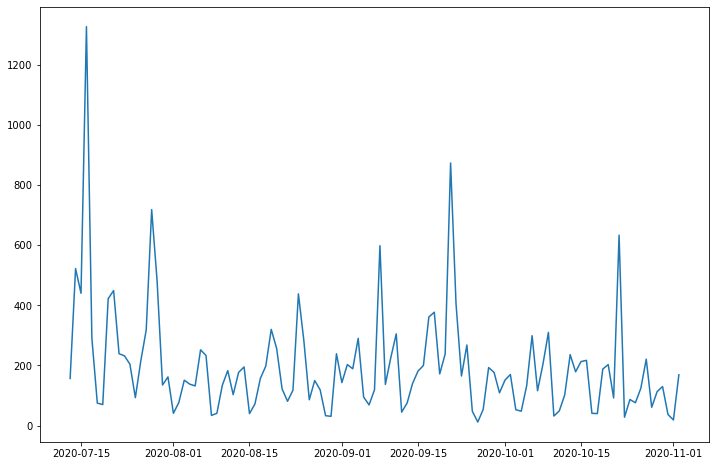

In [156]:
# Visualize Splits (Sanity Check)
x = darden_page_viewed.index
y = darden_page_viewed.page_view_count

plt.figure(figsize=(12, 8))
plt.plot(x,y)
plt.show()

***

## Can we mimic using the entire df?

In [155]:
# I had no idea you could identify a series to resample, that really makes this kind of easy

total_page_viewed = pd.DataFrame(df.page_viewed.resample('D').count())
total_page_viewed.columns = ['page_view_count']
total_page_viewed

,page_view_count
datetime,
2018-01-26,572
2018-01-27,230
2018-01-28,170
2018-01-29,830
2018-01-30,652
...,...
2020-10-29,1358
2020-10-30,912
2020-10-31,211


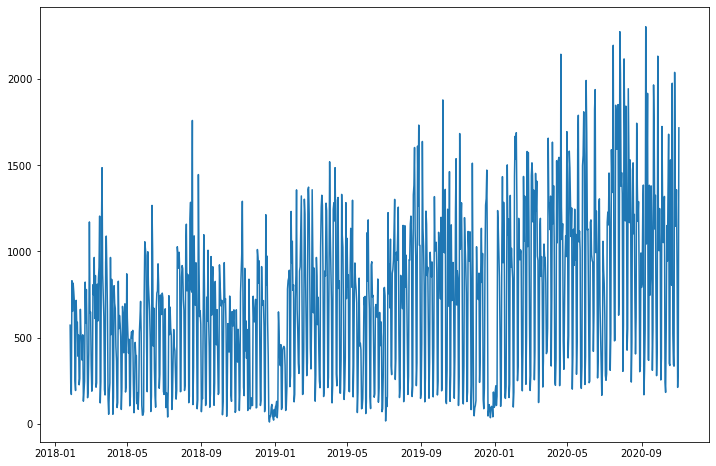

In [157]:
# Visualize Splits (Sanity Check)
x = total_page_viewed.index
y = total_page_viewed.page_view_count

plt.figure(figsize=(12, 8))
plt.plot(x,y)
plt.show()

***



## What do we do with Train?

In [140]:
train.head()

,ip_hits,midband,ub,lb,pct_b
datetime,,,,,
2018-02-01,1,1.000000,NaN,NaN,NaN
2018-02-02,0,0.483333,2.604654,-1.637987,0.386077
2018-02-03,0,0.311366,2.013990,-1.391257,0.408563
2018-02-04,0,0.225573,1.674769,-1.223622,0.422173
2018-02-05,0,0.174250,1.447956,-1.099456,0.431597
